## Read image file names from the image directory
Those with "range(8, 18)" indicates low-level change while those with "range(2, 4)" indicates high-level change

In [1]:
############################ Create a catalogue of images ############################
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from collections import defaultdict
import time
from itertools import compress

# Start time stamp
t = time.time()

# Get the list of image names in the folder
image_folder =  os.path.join(os.getcwd(), "Images")
list_all = os.listdir(image_folder)
is_file = [os.path.isfile(os.path.join(image_folder, list_name)) for list_name in list_all]
file_list = list(compress(list_all, is_file))

# Parse and create catalogue
max_list_length = 0;
file_name_parsed = []
image_catalogue = {}
for file_name in file_list:
    file_name = file_name[:-4]
    file_name_parsed_old = file_name_parsed
    file_name_parsed = file_name.split('_')
    if file_name_parsed[0] not in image_catalogue.keys():
        image_catalogue[file_name_parsed[0]] = {'mix_low': [], 'mix_high': []}
        if len(image_catalogue.keys()) > 1:
            max_list_length = max(max_list_length, len(image_catalogue[file_name_parsed_old[0]]['mix_low']), 
                                  len(image_catalogue[file_name_parsed_old[0]]['mix_high']))        
    else:    
        if file_name_parsed[1] == 'range(8, 18)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_low']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_low'] = current_list
        elif file_name_parsed[1] == 'range(2, 4)':
            current_list = image_catalogue[file_name_parsed[0]]['mix_high']
            if  len(current_list)==0:
                current_list = [file_name_parsed[2]]
            else:
                current_list.append(file_name_parsed[2])
            image_catalogue[file_name_parsed[0]]['mix_high'] = current_list

# End time stamp
elapsed = time.time() - t
print(elapsed)      


0.06838774681091309


## Load the images and compute the pixel-level difference

In [4]:
############################ Compute the pixel-level difference between original and mixed images ############################
# Time stamp
t = time.time()

# List of original seeds
seed_original = image_catalogue.keys()
mean_absolute_deviation = np.empty((len(seed_original), 2, max_list_length))
mean_absolute_deviation.fill(np.nan)

# Read in images and compute difference in pixel values
index_seed = 0;
n_images_pca = len(seed_original)
image_original_pca = []
image_mix_flat_low_pca = []
image_mix_flat_high_pca = []
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    image_original = plt.imread(file_path)
    image_mix_flat_low = []
    image_mix_flat_high = []
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                index_mix = 0                
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                index_mix = 1
            image_mix = plt.imread(file_path)
            
            if index_seed < n_images_pca:                
                if index_mix == 0:
                    image_mix_flat_low.append(image_mix.flatten())
                else:
                    image_mix_flat_high.append(image_mix.flatten())
                
            # Compute mean_absolute_deviation
            mean_absolute_deviation[index_seed, index_mix, index_list] = np.mean(np.absolute(image_mix - image_original))
 
    if index_seed < n_images_pca:
        image_original_pca.append(image_original.flatten())
        image_mix_flat_low_pca.append(image_mix_flat_low)
        image_mix_flat_high_pca.append(image_mix_flat_high)
        
    index_seed = index_seed + 1

# End time stamp
elapsed = time.time() - t
print(elapsed) 

43.670246601104736


## Perform PCA for a few images

136.23756790161133


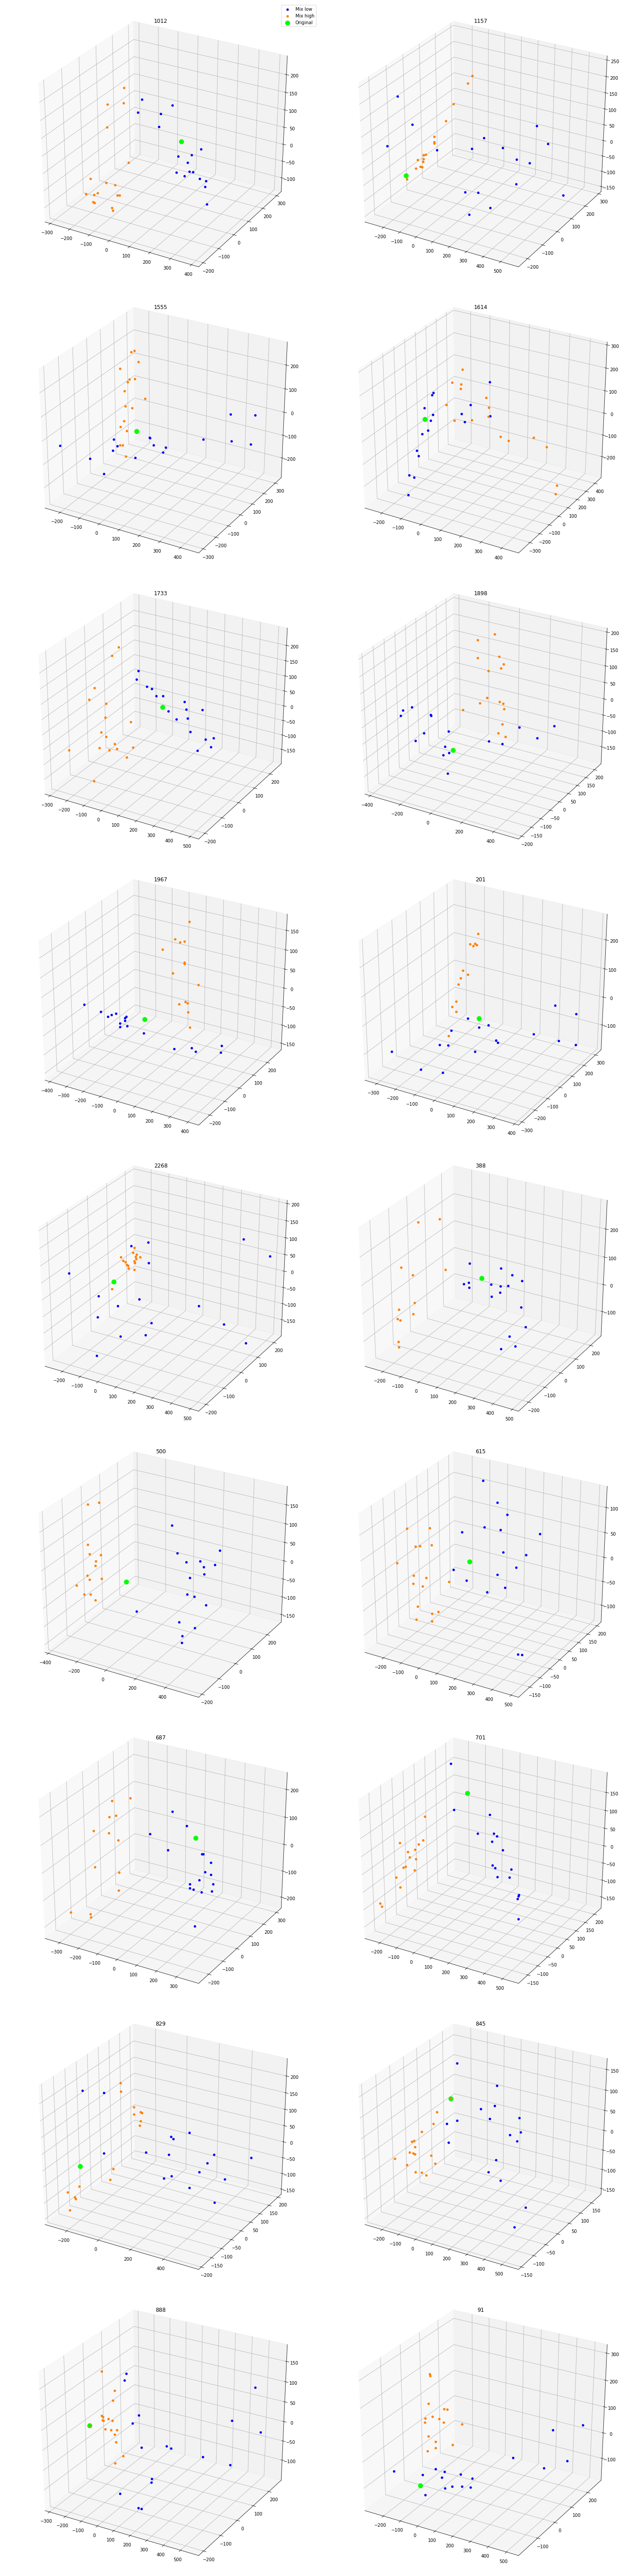

In [42]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# Time stamp
t = time.time()

fig = plt.figure(figsize=(20, 80))
n_col = 2
n_row = len(image_original_pca) / n_col
count = 1
ind_plot = list(seed_original)
for image_original, image_mix_low_all, image_mix_high_all in zip(image_original_pca, image_mix_flat_low_pca, image_mix_flat_high_pca):    
    image_mix_low_all = np.array(image_mix_low_all)
    image_mix_high_all = np.array(image_mix_high_all)
    image_original = np.expand_dims(image_original, axis=0)
    
    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    embed_transform = pca.fit_transform(np.concatenate((image_original, image_mix_low_all, image_mix_high_all), axis=0))
    embed_transform_low = embed_transform[1:len(image_mix_low_all)+1, :]
    embed_transform_high = embed_transform[len(image_mix_low_all)+1:, :]
    embed_transform_original = embed_transform[0, :]

    # Plot
    ax = fig.add_subplot(n_row, n_col, count, projection='3d')
    color_map = np.zeros((3, 3))
    color_map[0,:] = np.array([0, 0, 1])
    color_map[1,:] = np.array([1, 0.5, 0])
    color_map[2,:] = np.array([0, 1, 0])
    ax.scatter(xs=embed_transform_low[:, 0], ys=embed_transform_low[:, 1], zs=embed_transform_low[:, 2],
               depthshade=False, c=np.expand_dims(color_map[0], axis=0), label='Mix low')
    ax.scatter(xs=embed_transform_high[:, 0], ys=embed_transform_high[:, 1], zs=embed_transform_high[:, 2],
               depthshade=False, c=np.expand_dims(color_map[1], axis=0), label='Mix high')
    ax.scatter(xs=embed_transform_original[0], ys=embed_transform_original[1],
               zs=embed_transform_original[2], depthshade=False, c=np.expand_dims(color_map[2], axis=0), label='Original', s=100)
    ax.set_title(ind_plot[count-1])
    if count == 1:
        ax.legend()
    plt.tight_layout()    
    count = count + 1
    
plt.savefig("pca_embed_low.pdf")

# End time stamp
elapsed = time.time() - t
print(elapsed) 

## Plot the histogram of pixel-level difference for all images

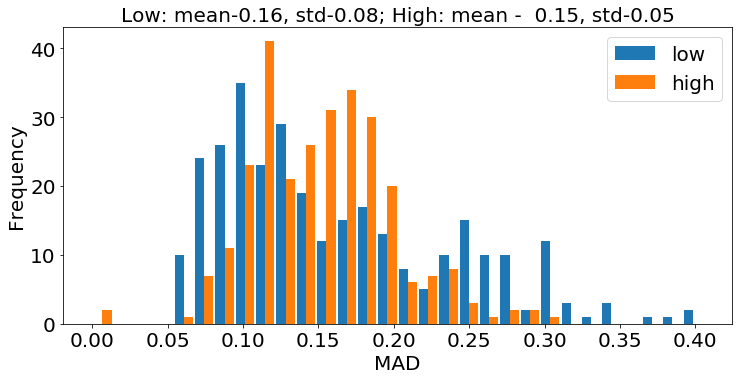

In [5]:
############################ Plot histogram of MAD difference low vs. high ############################
mad_low = mean_absolute_deviation[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)
mad_high = mean_absolute_deviation[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
std_mad_high = np.std(mad_high)

fig_size = 12
font_size = 20
fig = plt.figure(figsize=(fig_size, fig_size))
ax1 = fig.add_subplot(211)
n = plt.hist([mad_low, mad_high], bins=30, rwidth=0.9, label = ['low', 'high'])
ax1.tick_params(axis='both', which='major', labelsize=font_size)
ax1.set_ylabel('Frequency', fontsize = font_size)
ax1.set_xlabel('MAD', fontsize = font_size)
ax1.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean -  ", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2)]), fontsize = font_size)
ax1.legend(fontsize = font_size)

In [ ]:
############################ Get the images with MAD higher than threshold ############################
from collections import defaultdict

threshold_mad = 0.25
index_seed = 0;
file_high_mad = defaultdict(list)
for original_seed, mix_seed_both in image_catalogue.items(): 
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Mix image
            if mix_type == 'mix_low':
                file_name = ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"])
                index_mix = 0
            elif mix_type == 'mix_high':
                file_name = ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"])
                index_mix = 1

            # Check MAD
            if mean_absolute_deviation[index_seed, index_mix, index_list] > threshold_mad:
                file_high_mad[mix_type].append(file_name)
        
    index_seed = index_seed + 1

## Try contrast normalization

In [ ]:
############################ Contrast normalize mixed images relative to orginal images CHANNEL-WISE ############################
################### Also compute the MAD 
# Time stamp
t = time.time()

# Make new folder for contrast-normalized images
image_folder_new =  os.path.join(image_folder, "Contrast_normalized")
if os.path.isdir(image_folder_new)==False:
    os.mkdir(image_folder_new)

# List of original seeds
seed_original = image_catalogue.keys()
mad_cn = np.empty((len(seed_original), 2, max_list_length))
mad_cn.fill(np.nan)

# Read in images and compute difference in pixel values
index_seed = 0;
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    image_original = plt.imread(file_path)
    mean_im_orginal = np.mean(image_original, axis=(0,1))
    std_im_orginal = np.std(image_original, axis=(0,1))
    
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Load mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                file_path_save = os.path.join(image_folder_new, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                index_mix = 0
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                file_path_save = os.path.join(image_folder_new, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                index_mix = 1
                
            image_mix = plt.imread(file_path)
            mean_im_mixed = np.mean(image_mix, axis=(0,1))
            std_im_mixed = np.std(image_mix, axis=(0,1))
    
            # Contrast normalize mixed image relative to original image
            image_mix_cn = ((image_mix - mean_im_mixed) / std_im_mixed) * std_im_orginal + mean_im_orginal
            image_mix_cn[image_mix_cn>1] = 1.0
            image_mix_cn[image_mix_cn<0] = 0.0
            
            # Compute mean_absolute_deviation
            mad_cn[index_seed, index_mix, index_list] = np.mean(np.absolute(image_mix_cn - image_original))
            
            # Save the image
            plt.imsave(file_path_save, image_mix_cn)
        
    index_seed = index_seed + 1

# End time stamp
elapsed = time.time() - t
print(elapsed) 

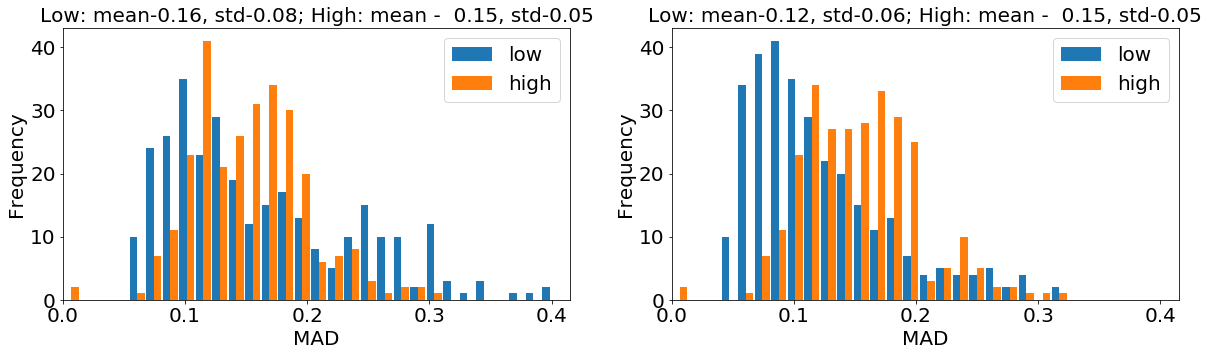

In [24]:
############################ Plot histogram of MAD with contrast normalized ############################
### No contrast normalized
mad_low = mean_absolute_deviation[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)
mad_high = mean_absolute_deviation[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
max_mad = np.max(np.concatenate([mad_low, mad_high])) + 0.01
std_mad_high = np.std(mad_high)


font_size = 20
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
n, bin_edge, patches = plt.hist([mad_low, mad_high], bins=30, rwidth=0.9, label = ['low', 'high'])
ax1.tick_params(axis='both', which='major', labelsize=font_size)
plt.xlim(0, max_mad)
ax1.set_ylabel('Frequency', fontsize = font_size)
ax1.set_xlabel('MAD', fontsize = font_size)
ax1.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean -  ", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2)]), fontsize = font_size)
ax1.legend(fontsize = font_size)

### Contrast normalized
mad_low = mad_cn[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)
mad_high = mad_cn[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
std_mad_high = np.std(mad_high)

ax2 = fig.add_subplot(1, 2, 2)
n = plt.hist([mad_low, mad_high], bins=bin_edge, rwidth=0.9, label = ['low', 'high'])
plt.xlim(0, max_mad)
ax2.tick_params(axis='both', which='major', labelsize=font_size)
ax2.set_ylabel('Frequency', fontsize = font_size)
ax2.set_xlabel('MAD', fontsize = font_size)
ax2.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean -  ", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2)]), fontsize = font_size)
ax2.legend(fontsize = font_size)
plt.savefig('histogram_low_high_contrastNorm.pdf', bbox_inches='tight')

## Try flipping the original images horizontally to get low-level change

29.914762258529663


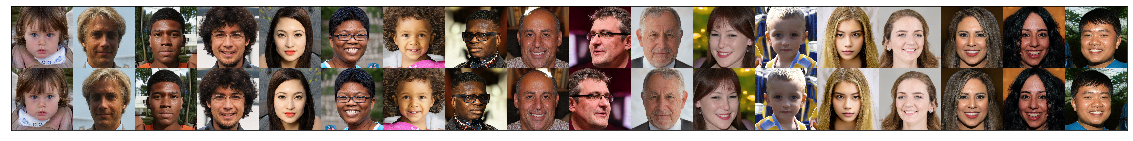

In [61]:
############################ Flip the original image horizontally ############################
import PIL.Image
# Time stamp
t = time.time()

# Make new folder for contrast-normalized images
image_folder_new =  os.path.join(image_folder, "Flip_horizontal")
if os.path.isdir(image_folder_new)==False:
    os.mkdir(image_folder_new)

# List of original seeds
seed_original = list(image_catalogue.keys())
mad_flip = np.empty(len(seed_original))
mad_flip.fill(np.nan)

# Make canvas of original + flip image
w = 1024
h = 1024
canvas = PIL.Image.new('RGB', (w * len(seed_original), h * 2), 'white')
            
# Read in images and compute difference in pixel values
index_seed = 0;
for original_seed in seed_original:
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    image_original = PIL.Image.open(file_path)
    canvas.paste(image_original, (index_seed * w, 0))

    # Flip image
    image_flip = np.fliplr(image_original)
    image_flip_save = PIL.Image.fromarray(image_flip, 'RGB')
    canvas.paste(image_flip_save, (index_seed * w, h))
    file_path_save = os.path.join(image_folder_new, ''.join([original_seed, "_range(8, 18)_", original_seed, ".png"]))

    # Compute mean_absolute_deviation
    image_original = np.array(image_original).astype(np.float)
    image_flip = image_flip.astype(np.float)
    mad_flip[index_seed] = np.mean(np.absolute(image_flip - image_original))

    # Save the image
    image_flip_save.save(file_path_save)            

    index_seed = index_seed + 1

mad_flip = mad_flip /255

# Save the image
all_images_path = os.path.join(image_folder_new, "all_images.png")
canvas.save(all_images_path)

# Plot the image
all_images = plt.imread(all_images_path)
plt.figure(figsize=(20, 30))
plt.imshow(all_images)
ax_current = plt.gca()
ax_current.axes.get_xaxis().set_visible(False)
ax_current.axes.get_yaxis().set_visible(False)

# End time stamp
elapsed = time.time() - t
print(elapsed) 

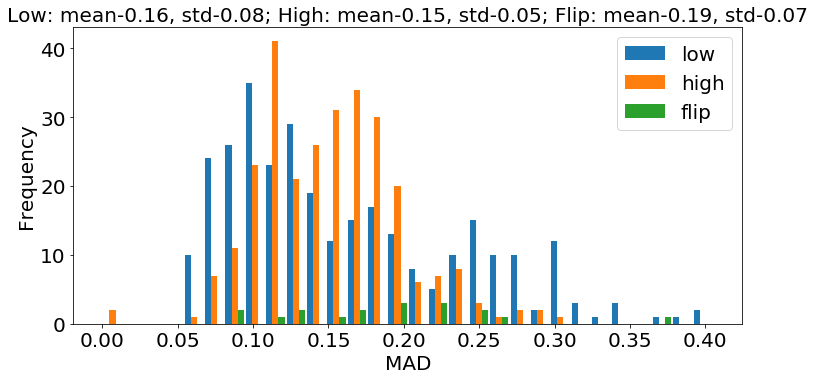

In [17]:
############################ Plot histogram of MAD flip ############################
mad_low = mean_absolute_deviation[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)

mad_high = mean_absolute_deviation[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
std_mad_high = np.std(mad_high)

mad_flip = mad_flip[~np.isnan(mad_flip)]
mean_mad_flip = np.mean(mad_flip)
std_mad_flip = np.std(mad_flip)

fig_size = 12
font_size = 20
fig = plt.figure(figsize=(fig_size, fig_size))
ax1 = fig.add_subplot(211)
n = plt.hist([mad_low, mad_high, mad_flip], bins=30, rwidth=0.9, label = ['low', 'high', 'flip'])
ax1.tick_params(axis='both', which='major', labelsize=font_size)
ax1.set_ylabel('Frequency', fontsize = font_size)
ax1.set_xlabel('MAD', fontsize = font_size)
ax1.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean-", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2), 
                       "; Flip: mean-", np.array2string(mean_mad_flip, precision=2), ", std-", np.array2string(std_mad_flip, precision=2)]),   
                        fontsize = font_size)
ax1.legend(fontsize = font_size)
plt.savefig('histogram_low_high_flip.pdf', bbox_inches='tight')

In [18]:
############################ Contrast normalize mixed images relative to orginal images ACROSS ALL CHANNELS ############################
################### Also compute the MAD 
# Time stamp
t = time.time()

# Make new folder for contrast-normalized images
image_folder_new =  os.path.join(image_folder, "Contrast_normalized_acrossAllChannel")
if os.path.isdir(image_folder_new)==False:
    os.mkdir(image_folder_new)

# List of original seeds
seed_original = image_catalogue.keys()
mad_cn_all_channel = np.empty((len(seed_original), 2, max_list_length))
mad_cn_all_channel.fill(np.nan)

# Read in images and compute difference in pixel values
index_seed = 0;
for original_seed, mix_seed_both in image_catalogue.items():
    # Original image
    file_path = os.path.join(image_folder, ''.join([original_seed, "_original.png"]))
    image_original = plt.imread(file_path)
    mean_im_orginal = np.mean(image_original)
    std_im_orginal = np.std(image_original)
    
    for mix_type, mix_seed_list in mix_seed_both.items():
        for index_list, mix_seed in enumerate(mix_seed_list):
            # Load mix image
            if mix_type == 'mix_low':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                file_path_save = os.path.join(image_folder_new, ''.join([original_seed, "_range(8, 18)_", mix_seed, ".png"]))
                index_mix = 0
            elif mix_type == 'mix_high':
                file_path = os.path.join(image_folder, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                file_path_save = os.path.join(image_folder_new, ''.join([original_seed, "_range(2, 4)_", mix_seed, ".png"]))
                index_mix = 1
                
            image_mix = plt.imread(file_path)
            mean_im_mixed = np.mean(image_mix)
            std_im_mixed = np.std(image_mix)
    
            # Contrast normalize mixed image relative to original image
            image_mix_cn = ((image_mix - mean_im_mixed) / std_im_mixed) * std_im_orginal + mean_im_orginal
            image_mix_cn[image_mix_cn>1] = 1.0
            image_mix_cn[image_mix_cn<0] = 0.0
            
            # Compute mean_absolute_deviation
            mad_cn_all_channel[index_seed, index_mix, index_list] = np.mean(np.absolute(image_mix_cn - image_original))
            
            # Save the image
            plt.imsave(file_path_save, image_mix_cn)
        
    index_seed = index_seed + 1

# End time stamp
elapsed = time.time() - t
print(elapsed) 

596.969212770462


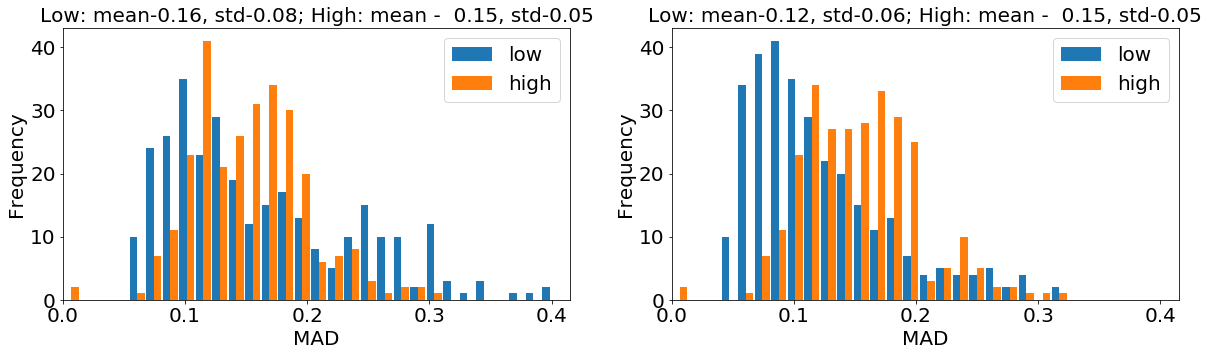

In [23]:
############################ Plot histogram of MAD with contrast normalized ############################
### No contrast normalized
mad_low = mean_absolute_deviation[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)
mad_high = mean_absolute_deviation[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
max_mad = np.max(np.concatenate([mad_low, mad_high])) + 0.01
std_mad_high = np.std(mad_high)


font_size = 20
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
n, bin_edge, patches = plt.hist([mad_low, mad_high], bins=30, rwidth=0.9, label = ['low', 'high'])
ax1.tick_params(axis='both', which='major', labelsize=font_size)
plt.xlim(0, max_mad)
ax1.set_ylabel('Frequency', fontsize = font_size)
ax1.set_xlabel('MAD', fontsize = font_size)
ax1.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean -  ", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2)]), fontsize = font_size)
ax1.legend(fontsize = font_size)

### Contrast normalized
mad_low = mad_cn_all_channel[:, 0, :].flatten()
mad_low = mad_low[~np.isnan(mad_low)]
mean_mad_low = np.mean(mad_low)
std_mad_low = np.std(mad_low)
mad_high = mad_cn_all_channel[:, 1, :].flatten()
mad_high = mad_high[~np.isnan(mad_high)]
mean_mad_high = np.mean(mad_high)
std_mad_high = np.std(mad_high)

ax2 = fig.add_subplot(1, 2, 2)
n = plt.hist([mad_low, mad_high], bins=bin_edge, rwidth=0.9, label = ['low', 'high'])
plt.xlim(0, max_mad)
ax2.tick_params(axis='both', which='major', labelsize=font_size)
ax2.set_ylabel('Frequency', fontsize = font_size)
ax2.set_xlabel('MAD', fontsize = font_size)
ax2.set_title(''.join(["Low: mean-", np.array2string(mean_mad_low, precision=2), ", std-", np.array2string(std_mad_low, precision=2), 
                       "; High: mean -  ", np.array2string(mean_mad_high, precision=2), ", std-", np.array2string(std_mad_high, precision=2)]), fontsize = font_size)
ax2.legend(fontsize = font_size)
plt.savefig('histogram_low_high_contrastNormAllChannel.pdf', bbox_inches='tight')

In [21]:
############################ Save variables ############################
import pickle
variable_folder =  os.path.join(os.getcwd(), "Variables")
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

# Save the variables    
with open(os.path.join(variable_folder, "variables_preprocess.pkl"), 'wb') as f:
    pickle.dump([mean_absolute_deviation, mad_cn, mad_flip, mad_cn_all_channel], f, protocol=-1)

# Load the variables    
# with open(os.path.join(variable_folder, "variables.pkl"), 'rb') as f:
#     mean_absolute_deviation, mad_cn, mad_flip = pickle.load(f)    

In [19]:
mad_cn_all_channel = mad_cn